# 학습 개선방향
### 데이터 
    - `04_07_FE_.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
### 검증 전략
    - 이전 검증전략 :    
        - 11월(date_block_num 34)을 맞추기 위해 과거의 11월(date_block_num 10, 22)를 검증셋으로 사용하여 하이퍼 파라미터 최적화
    - 문제점:
        - 데이터 부족: 첫 번째 폴드(0~9월 학습)는 데이터가 너무 적어 과소학습 되었을 가능성
        - 최신데이터 무시: 11월이라는 계절성(Seasonality)도 중요하지만, 시계열 데이터에서 가장 강력한 '직전 달(Lag 1)'의 데이터가 무시됨
    - 개선방안:
        - Fold 1: Train (0 ~ 32), Val (33) -> 가중치 1.0
        - Fold 2: Train (0 ~ 21), Val (22) -> 가중치 0.5 (계절성 반영용 보조 지표)
### 기타 로직
    - Target Clipping 시점
        - 이전에는 예측단계에서만 `clip(0, 20)`을 실행하였는데, 학습단계에서 `y_train` 자체를 `clip(0, 20)` 처리하고 학습하도록 수정

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
import warnings

%matplotlib inline

plt.style.use("seaborn-v0_8-white")

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')
all_data.shape

(8026950, 59)

# Model

## prepare

In [3]:
x_all = all_data[all_data['date_block_num'] <= 33]
x_all = x_all.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_all = all_data[all_data['date_block_num'] <= 33]['item_cnt_month'].clip(0, 20)

In [4]:
cat_features = ['shop_id', 'shop_type', 'type', 'subtype', 'item_category_id', 'city', 'month']

## optuna

In [5]:
%%time
fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'feature_pre_filter': False,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10)
    }
    
    folds = [
        (32, 33),  # 학습: 0~33월, 검증: 10월 (2015년)
        (21, 22)   # 학습: 0~22월, 검증: 11월 (2014년), 계절성 반영 보조 용도
    ]
    
    fold_scores = []
    best_iters = []
    
    for train_end_date, val_date in folds:
        train_mask = all_data['date_block_num'] <= train_end_date
        x_train = all_data.loc[train_mask].drop(['item_cnt_month'], axis=1)

        val_mask = all_data['date_block_num'] == val_date
        x_val = all_data.loc[val_mask].drop(['item_cnt_month'], axis=1)

        y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
        y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)
        
        dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
        dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)
        
        pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
        
        lgb_model = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=1500,
            valid_sets=[dval],
            valid_names=['eval'],
            callbacks=[
                early_stopping(stopping_rounds=150, verbose=False),
                log_evaluation(period=0),
                pruning_callback
            ]
        )
    
        best_iters.append(lgb_model.best_iteration)
    
        preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration).clip(0, 20)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        fold_scores.append(rmse)
    
    weighted_avg_rmse = (fold_scores[0] * 1.0 + fold_scores[1] * 0.5) / 1.5
    return weighted_avg_rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", 
        message=r"The reported value is ignored because this `step` .* is already reported.",
        category=UserWarning
    )
    study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

[I 2025-12-04 05:51:39,755] A new study created in memory with name: no-name-733da2b4-7853-4436-b733-35195aa76999


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-04 06:01:51,120] Trial 0 finished with value: 0.8468227769962883 and parameters: {'num_leaves': 127, 'learning_rate': 0.03862083925763863, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4}. Best is trial 0 with value: 0.8468227769962883.
[I 2025-12-04 06:14:53,004] Trial 1 finished with value: 0.8414625718198862 and parameters: {'num_leaves': 151, 'learning_rate': 0.02271629970193425, 'feature_fraction': 0.7463084687531312, 'bagging_fraction': 0.9821192096250286, 'bagging_freq': 9}. Best is trial 1 with value: 0.8414625718198862.
[I 2025-12-04 06:20:58,714] Trial 2 finished with value: 0.8437048309067938 and parameters: {'num_leaves': 191, 'learning_rate': 0.031624822084432416, 'feature_fraction': 0.5208589864093756, 'bagging_fraction': 0.8847289359689058, 'bagging_freq': 1}. Best is trial 1 with value: 0.8414625718198862.
[I 2025-12-04 06:35:15,905] Trial 3 finished with value: 0.8439115089101987 and parameters: {'num_leaves'

In [6]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 30
Best Trial : 24
Best Score : 0.83980
======================================== Best Parameters ========================================
num_leaves : 177
learning_rate : 0.041051870946165504
feature_fraction : 0.6299337508497085
bagging_fraction : 0.9926317138086884
bagging_freq : 4


/tmp/ipykernel_10904/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

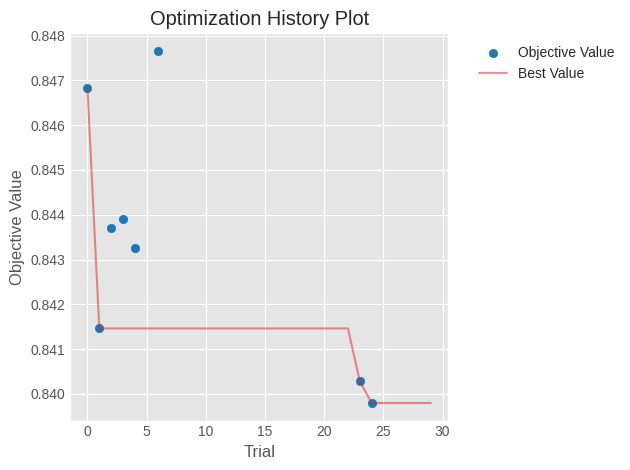

In [7]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_10904/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

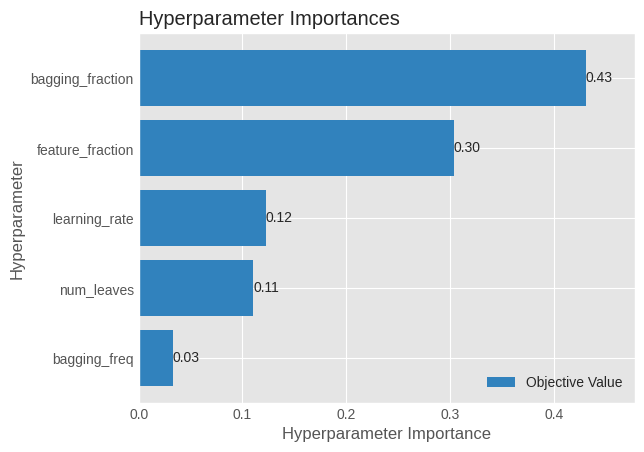

In [8]:
plot_param_importances(study_lgbm)

## validation

In [9]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)

In [10]:
train_mask = all_data['date_block_num'] <= 32
x_train = all_data.loc[train_mask].drop(['item_cnt_month'], axis=1)

val_mask = all_data['date_block_num'] == 33
x_val = all_data.loc[val_mask].drop(['item_cnt_month'], axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

In [11]:
%%time

val_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=1500,
    valid_sets=[dval],
    valid_names=['eval'],
    callbacks=[
        log_evaluation(period=100),
        early_stopping(stopping_rounds=150, verbose=False)
    ]
)

[100]	eval's rmse: 0.783214
[200]	eval's rmse: 0.778882
[300]	eval's rmse: 0.776468
[400]	eval's rmse: 0.776033
[500]	eval's rmse: 0.777337
CPU times: user 19min 9s, sys: 2.24 s, total: 19min 11s
Wall time: 5min 14s


In [12]:
print('Best score: ', val_lgbm_model.best_score['eval']['rmse'])
print('Best iteration: ', val_lgbm_model.best_iteration)

Best score:  0.7752444487268876
Best iteration:  368


/tmp/ipykernel_10904/1972124855.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


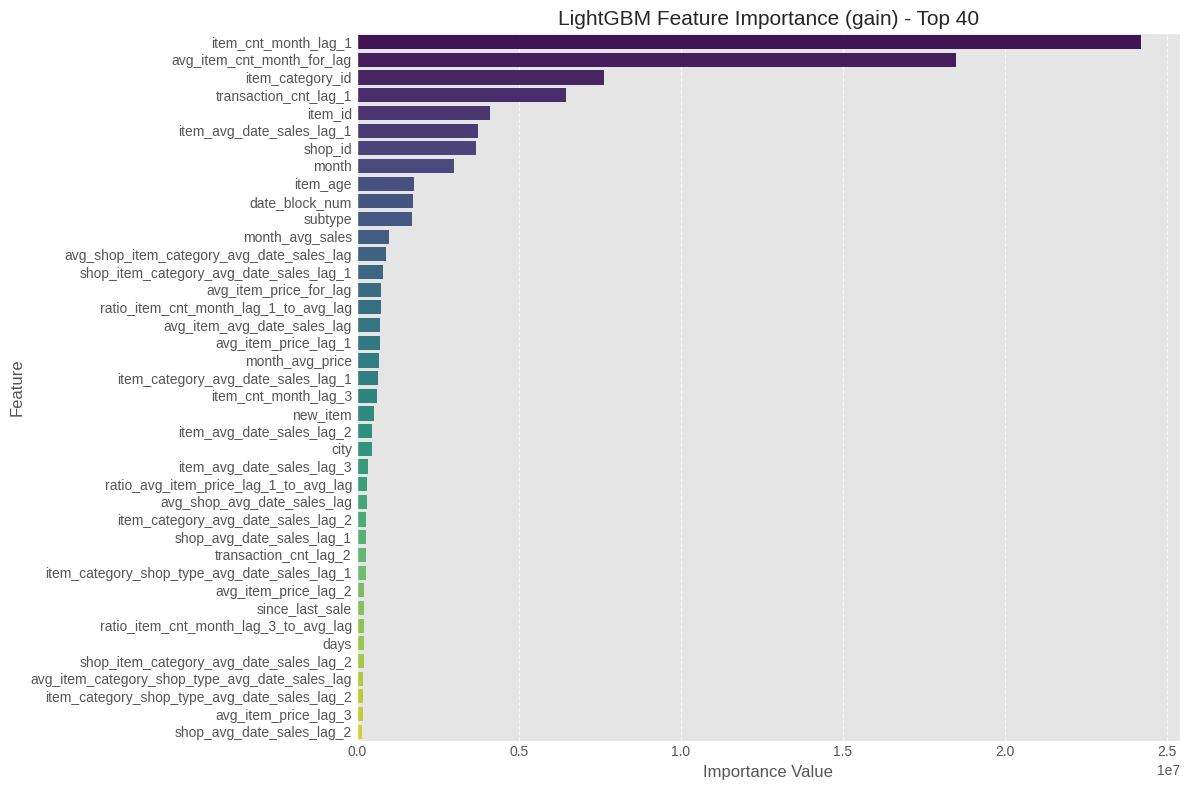

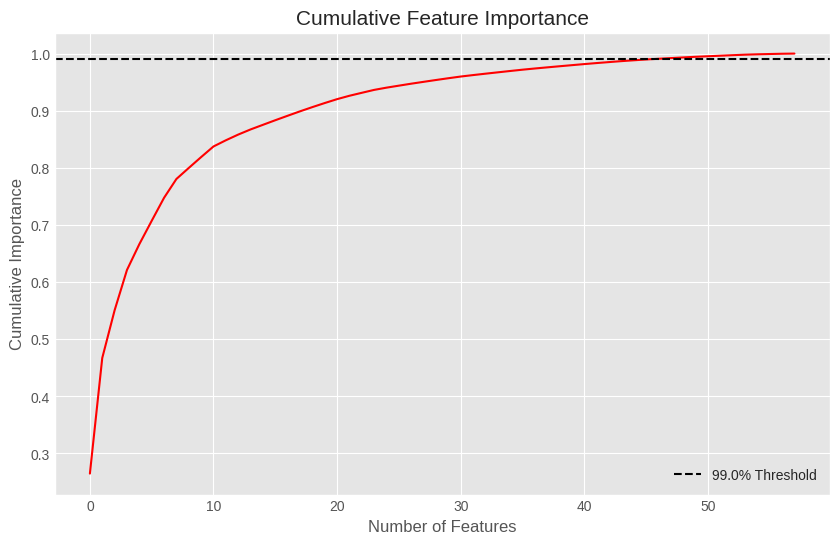

[GAIN] 분석 결과:
- 전체 피처 수: 58
- 99.0% 중요도를 설명하는 피처 수: 47
- 제거 추천 피처 수: 11
drop_cols :  ['type', 'delta_1_avg_item_price', 'item_category_shop_type_avg_date_sales_lag_3', 'transaction_cnt_lag_3', 'ratio_avg_item_price_lag_2_to_avg_lag', 'ratio_avg_item_price_lag_3_to_avg_lag', 'delta_2_avg_item_price', 'ratio_item_cnt_month_lag_2_to_avg_lag', 'delta_2_transaction_cnt', 'delta_2_item_cnt_month', 'shop_type']


In [13]:
def analyze_and_filter_features(model, importance_type='gain', cum_threshold=0.99):
    if isinstance(model, lgb.Booster):
        importance = model.feature_importance(importance_type=importance_type)
        feature_names = model.feature_name()
    else:
        importance = model.booster_.feature_importance(importance_type=importance_type)
        feature_names = model.booster_.feature_name()
        
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
    feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
    

    plt.figure(figsize=(12, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, selected_features, removed_features

df_imp, keep_cols, drop_cols = analyze_and_filter_features(val_lgbm_model, importance_type='gain', cum_threshold=0.99)
print('drop_cols : ', drop_cols)

## train

In [14]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(val_lgbm_model.best_iteration * 1.1)

In [15]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.787115
[200]	training's rmse: 0.752601
[300]	training's rmse: 0.73386
[400]	training's rmse: 0.720183
CPU times: user 15min 57s, sys: 1.76 s, total: 15min 59s
Wall time: 4min 14s


In [16]:
final_lgbm_model.save_model(data_path + '05_07_lgbm_model_v1.txt')

In [17]:
final_lgbm_model = lgb.Booster(model_file='./data/05_07_lgbm_model_v1.txt')

## prediction

In [18]:
predictions = final_lgbm_model.predict(x_test).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.455686
1,1,0.207317
2,2,1.030742
3,3,0.469090
4,4,2.003275


In [19]:
print(pd.Series(predictions).describe())

count    214200.000000
mean          0.294875
std           0.854872
min           0.000000
25%           0.020949
50%           0.076870
75%           0.250996
max          20.000000
dtype: float64


In [20]:
sub.to_csv(data_path + 'submssion_lgbm_model.csv', index=False)

In [21]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submssion_lgbm_model.csv" -m "05_07_submssion_v1"

100%|██████████████████████████████████████| 5.14M/5.14M [00:00<00:00, 11.3MB/s]
Successfully submitted to Predict Future Sales

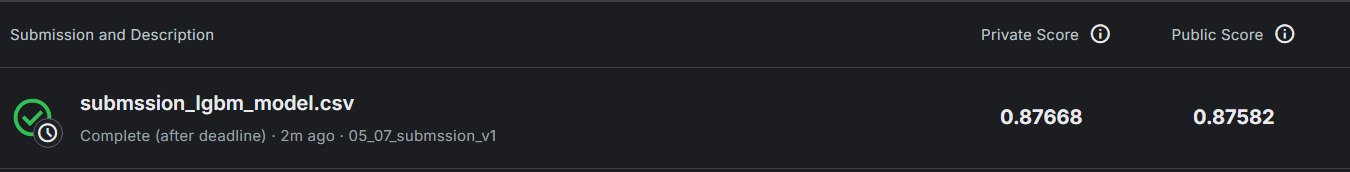